In [1]:
library(tidyverse)
library(patchwork)
library(bedtoolsr)

── Attaching packages ───────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.2
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0

── Conflicts ──────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message in fun(libname, pkgname):
“bedtoolsr was built with bedtools version 2.30.0 but you have version 2.31.0 installed. Function syntax may have changed and wrapper will not function correctly. To fix this, please install bedtools version 2.30.0 and either add it to your PATH or run:
options(bedtools.path = \"[bedtools path]\")”


In [2]:
# Function to load windowed Fst
load_windowed_fst <- function(path){
    city <- str_extract(basename(path), '^\\w+(?=_Chr)')
    
    colnames <- c('region', 'Chr', 'WinCenter', 'nSites_fst', 'fst')
    df <- suppressMessages(read_delim(path, delim = '\t', skip = 1, col_names = colnames)) %>%
        
        # Set negative Fst values to 0
        mutate(fst = ifelse(fst < 0, 0, fst)) %>% 
        mutate(city = city)
    
    return(df)
}

# Function to plot histogram of nSites for a single city
plot_nSites <- function(df, cutoff = 50){
    
    city <- df %>% pull(city) %>% unique()
    plt <- df %>% 
        ggplot(aes(x = nSites_fst)) +
            geom_histogram(bins = 100, color = 'black', fill = 'white') +
            geom_vline(xintercept = cutoff, color = 'red') +
            xlab('Number of sites in window') + ylab('Count of windows') +
            theme_classic()
    outpath <- paste0(figures_path, sprintf('/%s_nSites.pdf', city))
    ggsave(filename = outpath, plot = plt, device = 'pdf', width = 14, height = 14, units = 'in', dpi = 600)
}

# Function to identify Fst outlier windows for a single city
identify_fst_outlier_windows <- function(df){
    fst_quant_filt <- quantile(df %>% pull(fst), probs = c(0.99))

    df_mod <- df %>%
        mutate(fst_outlier = ifelse(fst >= fst_quant_filt, 1, 0)) %>%
        dplyr::select(city, Chr, start, end, WinCenter, fst, fst_outlier)
    
    return(df_mod)
}

In [3]:
# Load windowed Fst outlier analysis
results_prefix <- '/scratch/projects/trifolium/glue/glue_ps/results'
all_windowed_fst <- list.files(results_prefix, pattern = '*windowed.fst', full.names = TRUE, recursive = TRUE) %>% 
    purrr::map_dfr(., load_windowed_fst) %>% 
    mutate(region = str_extract(region, pattern = '(?<=\\()\\d+,\\d+(?=\\)$)')) %>% 
    separate(region, into = c('start', 'end'), sep = ',')

In [9]:
write_csv(all_windowed_fst, './all_windowed_fst.csv')

In [4]:
# Create histogram with number of sites in windows for each city
figures_path <- '/scratch/projects/trifolium/glue/glue_ps/figures/nSites_histograms'
dir.create(figures_path, showWarnings = FALSE)
all_windowed_fst %>% 
    group_split(city) %>% 
    purrr::walk(., plot_nSites)

In [5]:
# Identify outliers across genome
nSites_thresh <- 100
all_windowed_fst_filt <- all_windowed_fst %>%
    filter(nSites_fst > nSites_thresh) %>% 
    filter(!city %in% c('Antwerp', 'Armidale'))

all_windowed_fst_filt_with_outliers <- all_windowed_fst_filt %>% 
    group_split(city) %>% 
    purrr::map_dfr(., identify_fst_outlier_windows)

In [6]:
all_windowed_fst_filt_with_outliers %>% 
    group_by(city) %>% 
    summarise(total_wins = n(),
              num_outlier = sum(fst_outlier))

city,total_wins,num_outlier
<chr>,<int>,<dbl>
Albuquerque,44187,442
Athens,50578,506
Bogota,6017,61
Buenos_Aires,62826,629
Calgary,71266,713
Canberra,4621,47
Cape_Town,42519,426
Christchurch,50935,510
Kunming,72404,725


In [7]:
parallel_windows_hist <- all_windowed_fst_filt_with_outliers %>% 
    filter(fst_outlier == 1) %>% 
    group_by(Chr, WinCenter) %>% 
    summarise(n = n()) %>% 
    filter(n > 1) %>% 
    ggplot(aes(x = n)) +
        geom_histogram(bins = 4, color = 'black', fill = 'white') +
        xlab("Number of cities with signatures of selection") +
        ylab("Number of genomic windows") +
        theme_classic() +
        theme(axis.title = element_text(size = 18),
              axis.text = element_text(size = 16))

ggsave(filename = paste0(figures_path, '/parallel_windows_hist.pdf'), plot = parallel_windows_hist, device = 'pdf', 
       width = 10, height = 10, units = 'in', dpi = 600)

`summarise()` has grouped output by 'Chr'. You can override using the `.groups` argument.


In [8]:
all_windowed_fst_filt_with_outliers %>% 
    filter(fst_outlier == 1) %>% 
    group_by(Chr, WinCenter) %>% 
    summarise(n = n()) %>% 
    filter(n == 1)

`summarise()` has grouped output by 'Chr'. You can override using the `.groups` argument.


Chr,WinCenter,n
<chr>,<dbl>,<int>
Chr01_Occ,335000,1
Chr01_Occ,345000,1
Chr01_Occ,365000,1
Chr01_Occ,415000,1
Chr01_Occ,445000,1
Chr01_Occ,485000,1
Chr01_Occ,705000,1
Chr01_Occ,805000,1
Chr01_Occ,1145000,1


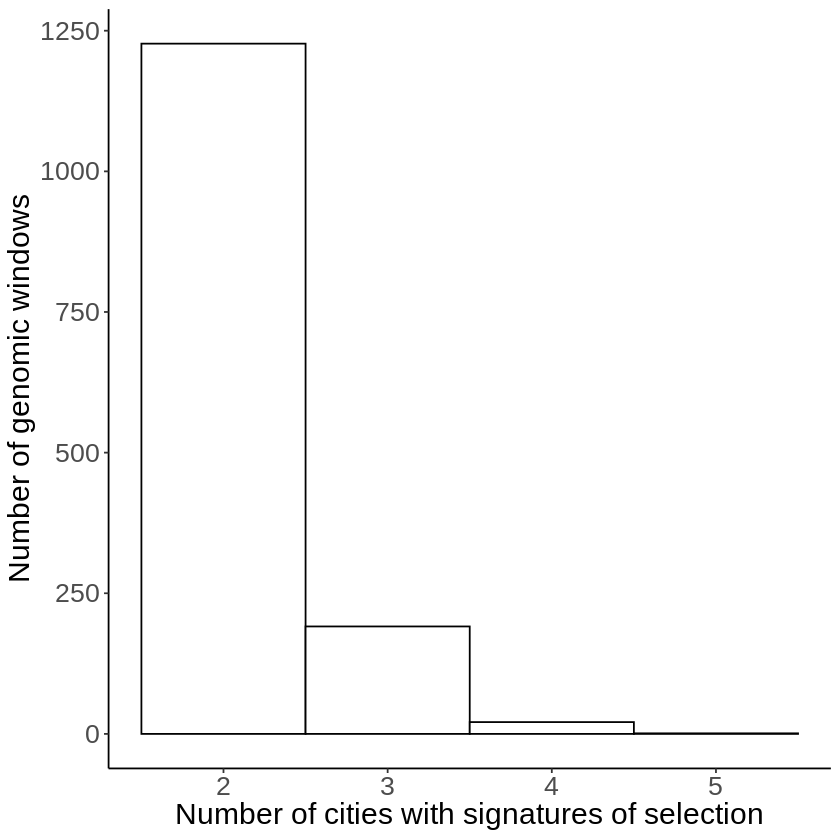

In [218]:
parallel_windows_hist

In [219]:
parallel_n4_windows <- all_windowed_fst_filt_with_outliers %>% 
    filter(fst_outlier == 1) %>% 
    group_by(Chr, start, end, WinCenter) %>% 
    summarise(n = n()) %>% 
    filter(n >= 4)

`summarise()` has grouped output by 'Chr', 'start', 'end'. You can override using the
`.groups` argument.


In [220]:
parallel_n4_windows <- all_windowed_fst_filt_with_outliers %>% 
    left_join(parallel_n4_windows, by = c('Chr', 'start', 'end', 'WinCenter')) %>% 
    filter(!is.na(n) & fst_outlier == 1)

In [261]:
parallel_n4_windows %>% filter(n == 4 & Chr == 'Chr04_Occ') %>% arrange(Chr, city)

city,Chr,start,end,WinCenter,fst,fst_outlier,n
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>
Albuquerque,Chr04_Occ,6480000,6490000,6485000,0.024851,1,4
Albuquerque,Chr04_Occ,29000000,29010000,29005000,0.030695,1,4
Buenos_Aires,Chr04_Occ,4880000,4890000,4885000,0.088801,1,4
Buenos_Aires,Chr04_Occ,4910000,4920000,4915000,0.104062,1,4
Buenos_Aires,Chr04_Occ,5580000,5590000,5585000,0.045324,1,4
Buenos_Aires,Chr04_Occ,6480000,6490000,6485000,0.034308,1,4
Buenos_Aires,Chr04_Occ,7210000,7220000,7215000,0.086680,1,4
Buenos_Aires,Chr04_Occ,14700000,14710000,14705000,0.045796,1,4
Calgary,Chr04_Occ,4880000,4890000,4885000,0.025379,1,4


In [276]:
formatter1e6 <- function(x){ 
    x <- x / 1e6
    return(sprintf(x, fmt = '%#.2f'))
}

create_manhattan_plot <- function(df, City, Chrom, windows_df){
    
    df_filt <- df %>% filter(city == City & Chr == Chrom)
    windows <- windows_df %>% filter(city == City & Chr == Chrom) %>% 
        dplyr::select(city, Chr, start, end) %>% 
        mutate(start = as.numeric(start), end = as.numeric(end))
    
    data_cum <- df_filt %>%
        group_by(city, Chr) %>% 
        summarise(max_WinCenter = max(WinCenter)) %>% 
        mutate(WinCenter_add = lag(cumsum(max_WinCenter), default = 0)) %>% 
        dplyr::select(city, Chr, WinCenter_add)

    df_filt_mod <- df_filt %>%
        inner_join(data_cum, by = c("city", "Chr")) %>% 
        mutate(WinCenter_cum = WinCenter + WinCenter_add) 

    max_y = max(df_filt_mod$fst) * 1.2

    manhat_plot <- df_filt_mod %>%
        mutate(fst_outlier = as.character(fst_outlier)) %>% 
        ggplot(aes(x = WinCenter_cum, y = fst)) +
            geom_point(shape = 21, size = 2, aes(color = fst_outlier, fill = fst_outlier)) +
            scale_x_continuous(labels = formatter1e6) +
            scale_y_continuous(expand = c(0,0)) +
            coord_cartesian(ylim = c(0, max_y)) +
            ylab('Fst') + xlab(Chrom) +
            ggtitle(City) +
            scale_color_manual(values = c('black', 'red')) +
            scale_fill_manual(values = c('black', 'red')) +
            geom_rect(data = windows, inherit.aes = FALSE, 
                      aes(xmin = start, xmax = end, ymin=-Inf, ymax = +Inf),
                      color = 'blue', fill = 'blue') +
            theme_classic() +
            theme(
                legend.position = "none",
                panel.border = element_blank(),
                panel.grid.major.x = element_blank(),
                panel.grid.minor.x = element_blank(),
                axis.text = element_text(size=16),
                axis.title = element_text(size=20),
#                 axis.text.x = element_blank(),
                plot.title = element_text(size = 22, face = 'bold')
              )
    
    return(manhat_plot)
}



In [282]:
windows_Chr01Pall <- parallel_n4_windows %>% filter(n == 5)
Alb <- create_manhattan_plot(all_windowed_fst_filt_with_outliers, 'Albuquerque', 'Chr01_Pall', windows_Chr01Pall)
Cal <- create_manhattan_plot(all_windowed_fst_filt_with_outliers, 'Calgary', 'Chr01_Pall', windows_Chr01Pall)
Chrt <- create_manhattan_plot(all_windowed_fst_filt_with_outliers, 'Christchurch', 'Chr01_Pall', windows_Chr01Pall)
Pa <- create_manhattan_plot(all_windowed_fst_filt_with_outliers, 'Punta_Arenas', 'Chr01_Pall', windows_Chr01Pall)
Teh <- create_manhattan_plot(all_windowed_fst_filt_with_outliers, 'Tehran', 'Chr01_Pall', windows_Chr01Pall)

`summarise()` has grouped output by 'city'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'city'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'city'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'city'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'city'. You can override using the `.groups` argument.


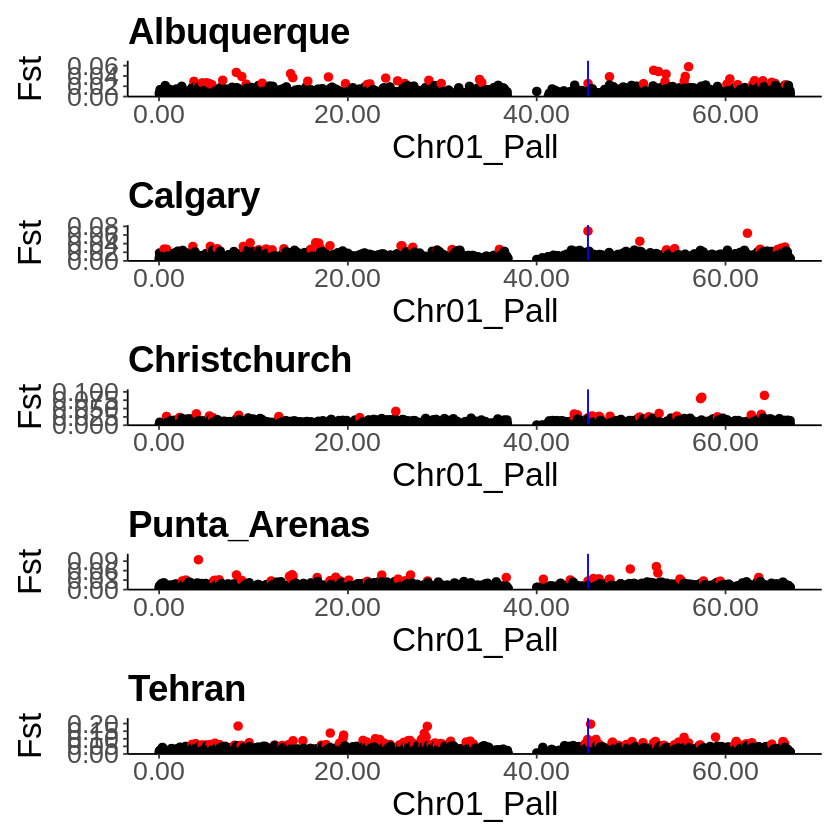

In [283]:
# x_axis <- cowplot::get_plot_component(Alb, "xlab-b")
parallel_Chr01Pall_manhat <- Alb / Cal / Chrt / Pa / Teh
parallel_Chr01Pall_manhat

In [284]:
figures_path <- '/scratch/projects/trifolium/glue/glue_ps/figures'
dir.create(figures_path, showWarnings = FALSE)
ggsave(filename = paste0(figures_path, '/parallel_Chr01Pall_manhat.pdf'), plot = parallel_Chr01Pall_manhat, device = 'pdf', 
       width = 14, height = 14, units = 'in', dpi = 600)

In [285]:
merge_fst_outlierWins <- function(df){
    city <- df %>% pull(city) %>% unique
    df_mod <- df %>% 
        dplyr::select(Chr, start, end, fst)
    df_merged <- bt.merge(i = df_mod, c = '4', o = 'count', d = 50000)
    
    names(df_merged) <- c('Chr', 'start', 'end', 'fst')
    df_merged <- df_merged %>% 
        mutate(winSize = end - start,
               city = city)

    return(df_merged)
}



In [287]:
windows_Chr04Occ <- parallel_n4_windows %>% 
    filter(n == 4 & Chr == 'Chr04_Occ') %>% 
    arrange(Chr, city) %>% 
    group_split(city) %>% 
    purrr::map_dfr(., merge_fst_outlierWins) %>% 
    filter(start >= 4880000 & end <= 4920000)
Ba <- create_manhattan_plot(all_windowed_fst_filt_with_outliers, 'Buenos_Aires', 'Chr04_Occ', windows_Chr04Occ)
Cal <- create_manhattan_plot(all_windowed_fst_filt_with_outliers, 'Calgary', 'Chr04_Occ', windows_Chr04Occ)
Pa <- create_manhattan_plot(all_windowed_fst_filt_with_outliers, 'Punta_Arenas', 'Chr04_Occ', windows_Chr04Occ)
Teh <- create_manhattan_plot(all_windowed_fst_filt_with_outliers, 'Tehran', 'Chr04_Occ', windows_Chr04Occ)
War <- create_manhattan_plot(all_windowed_fst_filt_with_outliers, 'Warsaw', 'Chr04_Occ', windows_Chr04Occ)

Chr,start,end,fst,winSize,city
<chr>,<int>,<int>,<int>,<int>,<chr>
Chr04_Occ,4880000,4920000,2,40000,Buenos_Aires
Chr04_Occ,4880000,4920000,2,40000,Calgary
Chr04_Occ,4910000,4920000,1,10000,Punta_Arenas
Chr04_Occ,4880000,4920000,2,40000,Tehran
Chr04_Occ,4880000,4890000,1,10000,Warsaw


`summarise()` has grouped output by 'city'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'city'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'city'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'city'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'city'. You can override using the `.groups` argument.


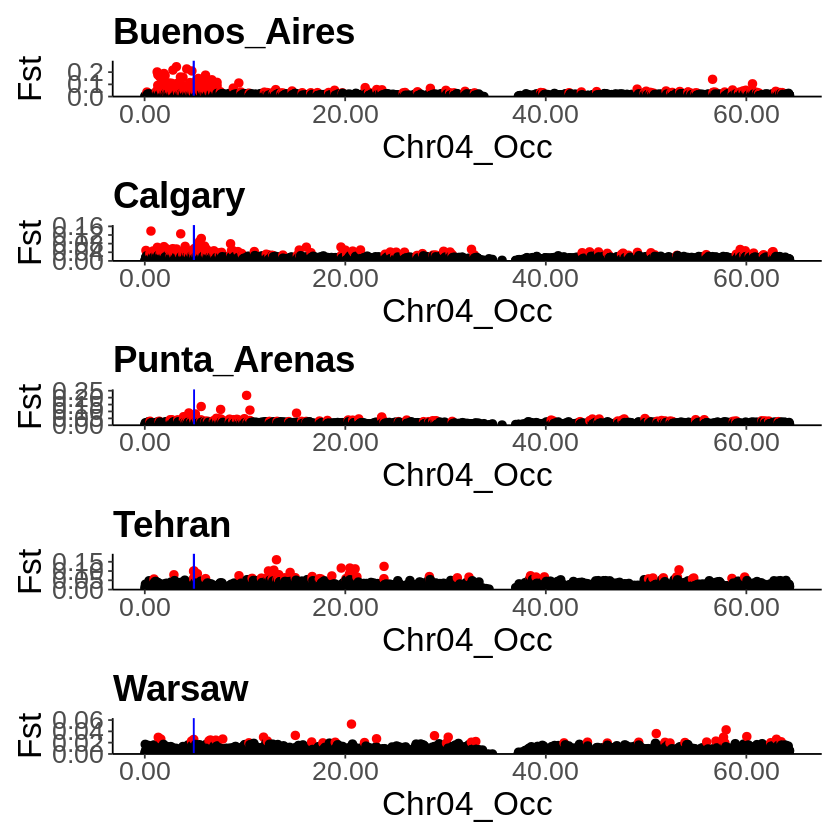

In [288]:
parallel_Chr04Occ_manhat <- Ba / Cal / Pa / Teh / War
parallel_Chr04Occ_manhat

In [289]:
ggsave(filename = paste0(figures_path, '/parallel_Chr04Occ_manhat.pdf'), plot = parallel_Chr04Occ_manhat, device = 'pdf', 
       width = 14, height = 14, units = 'in', dpi = 600)